<h3 align="center"><font size="6.5">Projet 8 : Déployez un modèle dans le cloud</font></h3>

<h3 align="center"><font size="5">Analyse des vecteurs</font></h3>

* [Chapitre 1 : Importation des données](#chapter1)
    * [Librairies et données](#section_1_1)
    * [Conversion des données](#section_1_2)
       
* [Chapitre 2 : Analyse des données](#chapter2)
    * [Création de fonction](#section_2_1)
    * [Optimisation de la perpléxité](#section_2_2)
    * [Représentation graphique](#section_2_3)
    * [Matrice de confusion](#section_2_4)

<a class="anchor" id="chapter1"></a>
# Chapitre 1 : Importation des données
Nous allons travailler sur les résultats obtenus après transformation d'images en un ensemble de vecteurs. Ces résultats ont été obtenus en utilisant un premier script et exécuté sur le cloud. Nous allons commencer par importer les librairies dont nous avons besoin ainsi que des résultats de la featurization.

<a class="anchor" id="section_1_1"></a>
## Librairies et données

In [1]:
# Nous allons avoir besoin de calculer un KMeans ainsi que le score ARI. 
# Pour éviter l'afficher d'un message d'avertissement, nous modifions un paramètre d'environnement système.

import os

os.environ["OMP_NUM_THREADS"]="2"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import cluster, metrics, manifold, decomposition, preprocessing, manifold
from sklearn.cluster import KMeans, MiniBatchKMeans

from scipy.optimize import linear_sum_assignment
from matplotlib import colors

resultat = pd.read_csv("resultats_featurize.csv", low_memory=False, index_col=0)

In [2]:
resultat = resultat.sort_values("label").reset_index(drop=True)

resultat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   path          373 non-null    object
 1   label         373 non-null    object
 2   pca_features  373 non-null    object
dtypes: object(3)
memory usage: 8.9+ KB


In [3]:
resultat.head()

,path,label,pca_features
0,s3://fk-p8-fruits/test/Apple Braeburn/r_39_100...,Apple Braeburn,[-3.51764843e+00 -1.79583510e+01 -1.69648453e+...
1,s3://fk-p8-fruits/test/Apple Braeburn/36_100.jpg,Apple Braeburn,[-3.03779535e+00 -1.75055389e+01 -1.04790522e+...
2,s3://fk-p8-fruits/test/Apple Braeburn/52_100.jpg,Apple Braeburn,[-4.26253206e+00 -1.65799452e+01 -1.69864460e+...
3,s3://fk-p8-fruits/test/Apple Braeburn/r_3_100.jpg,Apple Braeburn,[ -3.20796669 -13.16585459 0.8400425 6.51...
4,s3://fk-p8-fruits/test/Apple Braeburn/8_100.jpg,Apple Braeburn,[ -2.77875951 -17.62457099 -1.05174974 5.38...


Nous voyons que la variable pca_features qui contient les vecteurs à étudier sont sous format "string". Nous allons convertir cette variable en variable numérique.
<a class="anchor" id="section_1_2"></a>
## Conversion des données

Nous supprimons quelques caractéres qui ne devraient pas apparaître et nous ferons ensuite une séparation de cette variable en plusieurs variables contenant chacune une coordonnées des vecteurs.

In [4]:
resultat["pca_features"] = resultat["pca_features"].replace(r"\n", "", regex = True)
resultat["pca_features"] = resultat["pca_features"].replace(r"\[  ", "[", regex = True)
resultat["pca_features"] = resultat["pca_features"].replace(r"\[ ", "[", regex = True)

resultat["pca_features"] = resultat["pca_features"].replace(r"\[", "", regex = True)
resultat["pca_features"] = resultat["pca_features"].replace(r"\]", "", regex = True)
resultat["pca_features"] = resultat["pca_features"].replace(r"      ", " ", regex = True)
resultat["pca_features"] = resultat["pca_features"].replace(r"     ", " ", regex = True)
resultat["pca_features"] = resultat["pca_features"].replace(r"    ", " ", regex = True)
resultat["pca_features"] = resultat["pca_features"].replace(r"   ", " ", regex = True)
resultat["pca_features"] = resultat["pca_features"].replace(r"  ", " ", regex = True)

In [5]:
val = resultat["pca_features"].str.split((" "), expand=True)

In [6]:
val.head()

,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,67
0,-3.51764843e+00,-1.79583510e+01,-1.69648453e+00,5.96889932e+00,5.05406935e+00,-2.17138215e+00,-2.56781763e+00,-7.70121302e+00,5.40846361e+00,1.38321964e+00,...,-9.57458000e-02,-4.84835782e-01,-4.54153675e-01,3.11838910e-01,-8.12663955e-01,-4.82205344e-01,-1.12393138e+00,-4.10883714e-01,3.36216471e-01,None
1,-3.03779535e+00,-1.75055389e+01,-1.04790522e+00,4.73509725e+00,7.37673055e+00,-1.99883670e+00,-3.35776386e+00,-3.85399010e+00,-2.60512089e+00,2.32928081e+00,...,3.72636765e-01,-3.26005444e-01,-4.25532635e-01,3.16735947e-01,-1.11533613e+00,-9.57212953e-04,-1.05737760e+00,-1.33477240e+00,4.11130164e-01,None
2,-4.26253206e+00,-1.65799452e+01,-1.69864460e+00,5.67362677e+00,7.99277983e+00,-1.61199065e+00,-2.80005249e+00,-5.05391363e+00,-4.46647775e+00,2.91007602e+00,...,3.11203112e-01,-4.00543404e-03,-3.81074733e-01,3.42275299e-01,-9.79100975e-01,6.18079967e-02,-7.84397004e-01,-1.75540538e-01,-1.72444124e-01,None
3,-3.20796669,-13.16585459,0.8400425,6.51061084,1.45369041,-0.44824147,-1.87767323,-12.68443483,1.85100215,3.08001401,...,0.22855072,0.18375805,-0.97399732,0.48562016,-0.78676305,-0.08809656,-0.3135231,-0.18992845,0.99472126,None
4,-2.77875951,-17.62457099,-1.05174974,5.38084601,7.33903575,-2.22747396,-2.84646922,-4.62587811,-1.27385703,2.66923742,...,0.22040726,-0.29876037,-0.28574615,0.45545402,-1.06875839,-0.10851142,-1.27800706,-0.82505297,0.31744268,None


Nous avons réussi à créer un tableau de vecteur mais nous avons 68 colonnes au lieu de 67 colonnes. Nous regardons ce que contient la dernière colonne. Si celle-ci ne contient aucune valeur numérique, alors nous la supprimerons.

In [7]:
val[67].unique()

array([None, ''], dtype=object)

Nous allons supprimer la dernière colonne qui ne contient rien et convertir les 67 colonnes en valeurs numériques.

In [8]:
val = val.iloc[:,:-1]

for col in val.columns:
    val[col] = val[col].astype(float)
    
val.head()

,0,1,2,3,4,5,6,7,8,9,...,57,58,59,60,61,62,63,64,65,66
0,-3.517648,-17.958351,-1.696485,5.968899,5.054069,-2.171382,-2.567818,-7.701213,5.408464,1.383220,...,1.322952,-0.095746,-0.484836,-0.454154,0.311839,-0.812664,-0.482205,-1.123931,-0.410884,0.336216
1,-3.037795,-17.505539,-1.047905,4.735097,7.376731,-1.998837,-3.357764,-3.853990,-2.605121,2.329281,...,0.875151,0.372637,-0.326005,-0.425533,0.316736,-1.115336,-0.000957,-1.057378,-1.334772,0.411130
2,-4.262532,-16.579945,-1.698645,5.673627,7.992780,-1.611991,-2.800052,-5.053914,-4.466478,2.910076,...,1.511517,0.311203,-0.004005,-0.381075,0.342275,-0.979101,0.061808,-0.784397,-0.175541,-0.172444
3,-3.207967,-13.165855,0.840043,6.510611,1.453690,-0.448241,-1.877673,-12.684435,1.851002,3.080014,...,2.221196,0.228551,0.183758,-0.973997,0.485620,-0.786763,-0.088097,-0.313523,-0.189928,0.994721
4,-2.778760,-17.624571,-1.051750,5.380846,7.339036,-2.227474,-2.846469,-4.625878,-1.273857,2.669237,...,1.214638,0.220407,-0.298760,-0.285746,0.455454,-1.068758,-0.108511,-1.278007,-0.825053,0.317443


Après quelques étapes, nous avons un jeu de données prêt à être analyser. Le but de l'analyse est de déterminer si le modèle et la réduction dimensionnelle par ACP a permis de créer des vecteurs qui peuvent être classés selon la catégorie des images. 

Pour vérifier cela, nous allons :
- effectuer une réduction dimensionnelle des vecteurs en 2 dimensions par un t-SNE,
- segmenter les données nouvellement réduites via un KMeans et
- comparer les labels d'origines avec les labels données par le KMeans.

<a class="anchor" id="chapter2"></a>
# Chapitre 2 : Analyse des données
Nous allons commencer par définir quelques fonctions qui seront utilisées pour réaliser les étapes précédemment décrites.
La réduction dimensionnelle doit être optimisée et notamment la perpléxité. Pour cela, nous allons effectuer une segmentation pour chaque réduction dimensionnelle réalisée pour certaines valeurs de perplexité. Ensuite nous calculons le score ARI obtenu pour une perplexité donnée. La perplexité choisie sera celle où le score ARI sera le plus grand.

<a class="anchor" id="section_2_1"></a>
## Création de fonctions

In [9]:
def best_perplexity(ref, X, model, perp_min = 5, perp_max = 105, step = 5, n_clusters = 7, long = 3.5, larg = 2):
    
    ARI = []
    ARI_tuned = []
    liste_perp = np.arange(perp_min, perp_max, step).tolist()
    
    for i in range (perp_min, perp_max, step):
        tsne = manifold.TSNE(n_components=2, perplexity = i, init='random', 
                             learning_rate = "auto", n_iter = 1000, random_state = 0)
        
        X_tsne = tsne.fit_transform(X)
                
        k_means = KMeans(n_clusters = n_clusters, init = "k-means++", random_state = 0, n_init="auto").fit(X_tsne)
                
        ARI.append(np.round(metrics.adjusted_rand_score(ref, k_means.labels_),5))
    
    plt.figure(figsize=(long, larg))
    
    plt.plot(liste_perp, ARI, marker = "o", color = "silver")
    
    plt.xlabel("Perplexité", fontsize = 10)
    plt.ylabel("Score ARI", fontsize = 10)
        
    plt.xticks(fontsize = 9)
    plt.yticks(fontsize = 9)
        
    plt.title(f"Distribution du score ARI selon \nla perplexité ({model})", fontsize = 12)    
    
    best_p = liste_perp[ARI.index(max(ARI))]
    print("=================================================================================================")
    print(f"Le score ARI est maximal pour une perplexité de {best_p}")
    print("=================================================================================================")
        
    return best_p

Nous créeons une fonction permettant de représenter graphiquement les variables réduites (où la perplexité a été déterminée au préalable) et chaque observable sera colorée selon le label auquel il appartient. Nous présenterons deux graphiques comparatifs :
- un graphique où les labels sont les labels originaux et
- un graphique où les labels sont ceux déterminés après avoir fait une segmentation par KMeans.

In [10]:
def score_ARI(model, perp, X, ref, n_clusters = 5):
    
    tsne = manifold.TSNE(n_components=2, perplexity = perp, init='random', 
                         learning_rate = "auto", n_iter = 1000, random_state=0)
    
    X_tsne = tsne.fit_transform(X)
    
    k_means = KMeans(n_clusters = n_clusters, init = "k-means++", random_state = 0, n_init="auto").fit(X_tsne)
    
    ARI = np.round(metrics.adjusted_rand_score(ref, k_means.labels_),5)
    
    print("=================================================================================================")
    print(f"Pour le modèle {model}, le score ARI est : {ARI}")
    print("=================================================================================================")
    
    lab = k_means.predict(X_tsne)
        
    return ARI, X_tsne, lab


def graph_t_sne(model, perp, X, ref, n_clusters = 5, long = 10, larg = 2):
    
    ARI, X_tsne, lab_model = score_ARI(model, perp, X, ref, n_clusters = 5)
    
    lab = [lab_model, ref]
    k = 0
        
    plt.figure(figsize=(long, larg))
        
    plt.subplot(1,2,1)
    
    sns.scatterplot(x = X_tsne[:,0], 
                    y = X_tsne[:,1],
                    hue = lab[0],
                    legend = 'full',
                    palette="deep")
    
    plt.xlabel("Variable t-SNE 1", fontsize = 10)
    plt.ylabel("Variable t-SNE 2", fontsize = 10)
            
    plt.xticks(fontsize = 9)
    plt.yticks(fontsize = 9)
    
    plt.legend(frameon = False, bbox_to_anchor=(1.2,1), fontsize = 9)
    
    plt.title(f"Segmentation avec {model} \n(labels = prédictions)", fontsize = 12)
                
    plt.subplot(1,2,2)
    sns.scatterplot(x = X_tsne[:,0], 
                    y = X_tsne[:,1],
                    hue = lab[1],
                    legend = 'full',
                    palette="deep")
            
    plt.xlabel("Variable t-SNE 1", fontsize = 10)
    plt.ylabel("Variable t-SNE 2", fontsize = 10)
            
    plt.xticks(fontsize = 9)
    plt.yticks(fontsize = 9)
            
    plt.legend(frameon = False, bbox_to_anchor=(1.2,1), fontsize = 9)
    
    plt.title(f"Segmentation avec {model} \n(labels = catégories)", fontsize = 12)
    
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.99, 
                        wspace=0.6, 
                        hspace=0)
    
    plt.show()
    
    return ARI, lab_model

Dans un premier temps, nous créeons une fonctions permettant de créer une matrice de confusion et de faire correspondre les labels obtenus avec le KMeans avec les labels originaux. 
Dans un second temps, nous créeons une fonction qui va afficher la matrice de confusion.

In [11]:
def confusion_matrix(ref_series, model_series):
    
    confusion_matrix = pd.crosstab(ref_series, model_series, 
                                   rownames = ['Données'], colnames = ['Modelisé'], margins=True)
    
    row_idx, col_idx = linear_sum_assignment(-confusion_matrix.iloc[:-1,:-1])
    row_idx = row_idx.tolist()
    col_idx = col_idx.tolist()
    row_idx.append(5)
    col_idx.append(5)
    
    confusion_matrix_rearranged = confusion_matrix.iloc[row_idx, col_idx]
    
    return confusion_matrix_rearranged

def graph_matrix(ref_series, model_series, model, long_fig = 10, haut_fig = 4):
    
   
    mat = confusion_matrix(ref_series, model_series)
        
    categ_x = ["Pomme\nBraeburn", "Pomme\nCrimson\nsnow", "Pomme\nGranny\nsmith", 
               "Maïs", "Salak"]
    
    categ_y = ["Pomme\nBraeburn", "Pomme\nCrimson snow", "Pomme\nGranny smith", 
               "Maïs", "Salak"]
    
    plt.figure(figsize=(long_fig, haut_fig))
        
    liste_col_conf = mat.columns
    for col in liste_col_conf[:-1]:
        mat[col] = mat[col]*100/mat["All"]
        

    cmap = plt.colormaps["Blues"]
    boundaries = np.arange(0,110,10)
    norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)
        
    plt.matshow(mat.iloc[:-1,:-1],cmap = cmap, fignum = False , norm = norm)
        
    for (x, y), value in np.ndenumerate(mat.iloc[:-1,:-1].T):
        plt.text(x, y, f"{value:.1f}", va="center", ha="center", fontsize = 9.5, 
                 bbox=dict(boxstyle='round', facecolor='white', edgecolor='1'))
                    
           
    plt.xticks(range(len(categ_x)), categ_x, fontsize=10, rotation=45)
    plt.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
    plt.yticks(range(len(categ_y)), categ_y, fontsize=10)
        
    plt.xlabel("Données", fontsize=14, labelpad=10)
    plt.ylabel("Modélisation",fontsize=14, labelpad=10)
        
    plt.colorbar(fraction=0.046, pad=0.02).ax.tick_params(labelsize=10)
       
    plt.title(f"Matrice de confusion\n({model})", fontsize=14)
        
    plt.show()

<a class="anchor" id="section_2_2"></a>
## Optimisation de la perplexité

Nous allons utiliser la fonction créee pour l'optimisation de la perplexité. Nous commencons d'abord par créér les labels sous forme numérique où chaque catégorie de fruits est associé à un entier.

In [12]:
X_features_mobile = val.values
X_features_mobile.shape

(373, 67)

In [13]:
fruits = resultat["label"].unique()
print(fruits)
k=0
for fr in fruits:
    resultat.loc[resultat["label"]==fr,"categ_label"] = k
    k+=1

resultat["categ_label"] = resultat["categ_label"].astype(int)

['Apple Braeburn' 'Apple Crimson Snow' 'Apple Granny Smith' 'Corn' 'Salak']


In [14]:
lab_app_b = resultat.loc[resultat["label"]=="Apple Braeburn","categ_label"].unique().item()
lab_app_cs = resultat.loc[resultat["label"]=="Apple Crimson Snow","categ_label"].unique().item()
lab_app_g = resultat.loc[resultat["label"]=="Apple Granny Smith","categ_label"].unique().item()
lab_mais = resultat.loc[resultat["label"]=="Corn","categ_label"].unique().item()
lab_salak = resultat.loc[resultat["label"]=="Salak","categ_label"].unique().item()

label_f = [lab_app_b, lab_app_cs, lab_app_g, lab_mais, lab_salak]

for i in range (5):
    print(f"Le label associé à la catégorie {fruits[i]} est {label_f[i]}")

Le label associé à la catégorie Apple Braeburn est 0
Le label associé à la catégorie Apple Crimson Snow est 1
Le label associé à la catégorie Apple Granny Smith est 2
Le label associé à la catégorie Corn est 3
Le label associé à la catégorie Salak est 4


In [15]:
lab_category = resultat["categ_label"].values
n_clusters = len(fruits)

Le score ARI est maximal pour une perplexité de 25


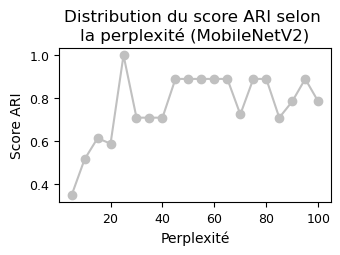

In [16]:
best_perp_mobile = best_perplexity(lab_category, X_features_mobile, "MobileNetV2", 
                                   perp_min = 5, perp_max = 101, step = 5, n_clusters = 5)

Nous voyons que le score ARI est maximum pour une perplexité de 25. Nous allons déterminer le score ARI entre 20 et 30 afin de savoir pour quelle valeur de perplexité précise nous avons un score ARI de 1.

Le score ARI est maximal pour une perplexité de 22


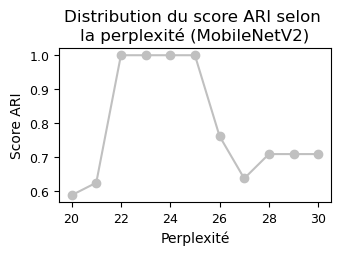

In [17]:
best_perp_mobile = best_perplexity(lab_category, X_features_mobile, "MobileNetV2", 
                                   perp_min = 20, perp_max = 31, step = 1, n_clusters = 5)

<a class="anchor" id="section_2_3"></a>
## Représentation graphique

Nous allons représenter graphiquement les variables réduites où la perplexité a été optimisée.

Pour le modèle MobileNetV2, le score ARI est : 1.0


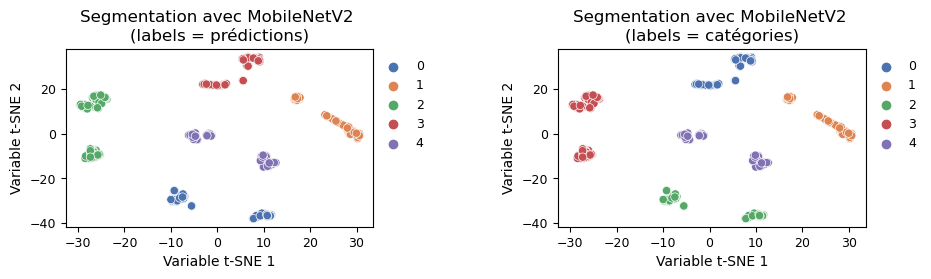

In [18]:
ARI_mobile, label_mobile = graph_t_sne("MobileNetV2", best_perp_mobile, X_features_mobile, lab_category, n_clusters = 5)

<a class="anchor" id="section_2_4"></a>
## Matrice de confusion

Enfin, nous représentons la matrice de confusion pour déterminer les pourcentages de correspondances entre les catégories réelles et prédites.

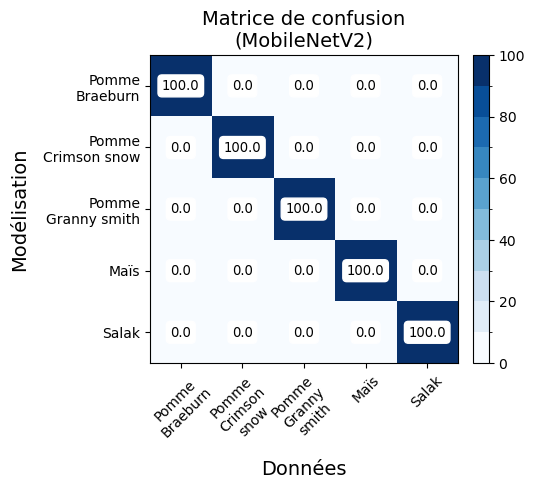

In [19]:
resultat["label_predict"] = label_mobile
graph_matrix(resultat["categ_label"], resultat["label_predict"], "MobileNetV2")